# Data pre-processing & Model Building

## Importing Libraries & loading the data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as pp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


pd.set_option('max.columns', None)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thyroid detection Project/hypothyroid.csv', na_values=['?'])
data.sample(3)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
1718,68.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,P
419,83.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,2.40,t,1.2,t,99.0,t,0.88,t,112.0,f,NaN,other,P
2639,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,t,t,0.98,t,2.5,t,120.0,t,1.06,t,113.0,f,NaN,SVHC,P


In [ ]:
cols_to_drop = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured',
       'FTI measured', 'TBG measured', 'TBG']
df = data.copy()
df.drop(columns = cols_to_drop, axis = 1, inplace = True)
df.sample(3)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,binaryClass
1842,56.0,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,1.5,NaN,103.0,1.07,97.0,SVI,P
359,34.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.3,2.5,121.0,1.29,94.0,SVHC,P
2832,49.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,1.9,1.8,81.0,0.91,88.0,other,P


## Missing value Imputation & removing outliers

- From the `EDA` part we know that `age` contains one outlier & we will simply remove that.

In [ ]:
drop_idx = df[df['age'] == df['age'].max()].index[0]
print('No. of rows before removing outlier: {}'.format(len(df)))
df.drop(index = drop_idx, axis = 0, inplace = True)
print('No. of rows after removing outlier: {}'.format(len(df)))

No. of rows before removing outlier: 3772
No. of rows after removing outlier: 3771


### Imputing Missing Values


In [ ]:
df.isna().sum()

age                            1
sex                          150
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral source                0
binaryClass                    0
dtype: int64

- As discussed earlier,
1. We will replace the `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI` with the median.
2. `sex` with the mode.

In [ ]:
X = df.drop('binaryClass', axis = 1)
y = df['binaryClass']
d = {'P':1,
     'N':0}
y = y.map(d)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 0)

## Encoding the categorical variables and creating the pipeline

In [ ]:
X.head(3)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,1.30,2.5,125.0,1.14,109.0,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,4.10,2.0,102.0,NaN,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,0.98,NaN,109.0,0.91,120.0,other


In [ ]:
cat_cols = ['sex', 'on thyroxine', 'query on thyroxine', \
                  'on antithyroid medication', 'sick', 'pregnant',\
                  'thyroid surgery', 'I131 treatment', 'query hypothyroid', \
                  'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',\
                  'psych', 'referral source']

num_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [ ]:
imp_num = Pipeline([
                    ('imp', SimpleImputer(strategy = 'median')),
                     ('scaler', MinMaxScaler())
                    ])
imp_cat = Pipeline([
                    ('imp2', SimpleImputer(strategy = 'most_frequent')), 
                     ('encode', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
                    ])

ct = make_column_transformer(
    
     (imp_cat, cat_cols),
     (imp_num, num_cols)
    , remainder='passthrough')

## Handling Imbalance

In [ ]:
smt = SMOTEENN(random_state = 0)

## Model Building

In [ ]:
def fit_model(model, param_dict):
  pipeline1 = pp([
                ('pre-processing', ct),
               ('smote', smt),
                ('learner', model)
                ])
  search = RandomizedSearchCV(pipeline1, param_distributions=param_dict, n_iter = 50, random_state=0)
  search.fit(X_train, y_train)
  return search.best_params_, search.best_score_

In [ ]:
import matplotlib.pyplot as plt
def prediction(model, X_tr, y_tr, X, y):
  preds_tr = model.predict(X_tr)
  print('TRAINING DATA:')
  print(classification_report(y_tr, preds_tr))
  print('-----------------------------------------')
  preds = model.predict(X)
  print('TEST DATA:')
  print(classification_report(y, preds))
  print('-----------------------------------------')
  fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
  plot_confusion_matrix(model, X, y, ax = ax[1])
  ax[1].set_title('TEST DATA')
  plot_confusion_matrix(model, X_tr, y_tr, ax = ax[0])
  ax[0].set_title('TRAINING DATA')

### 1. Logistic Regression

In [ ]:
params = {'learner__penalty':['l1', 'l2', 'elasticnet'],
          'learner__C':[0.2, 0.5, 0.8, 1, 1.2, 1.5, 2],
          'learner__solver':['newton-cg', 'lbfgs', 'liblinear', 'saga']}
lr_params, lr_score = fit_model(LogisticRegression(), params)
lr_params, lr_score

In [ ]:
pipeline = pp([
                ('pre-processing', ct),
               ('smote', smt),
                ('learner', LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 2))
])


model = pipeline.fit(X_train, y_train)

In [ ]:
prediction(model, X_train, y_train, X_test, y_test)

### 2. Decision Tree

In [ ]:
params = {'learner__criterion':['gini', 'entropy'],
          'learner__max_depth':[None, 64, 32, 16, 8]}

dt_params, dt_score = fit_model(DecisionTreeClassifier(), params)
dt_params, dt_score

In [ ]:
pipeline = pp([
                ('pre-processing', ct),
               ('smote', smt),
                ('learner', DecisionTreeClassifier(criterion = 'gini', max_depth = 8))
])

model = pipeline.fit(X_train, y_train)

In [ ]:
prediction(model,X_train, y_train, X_test, y_test)

### 3. Random Forest Classifier

In [ ]:
params = {'learner__n_estimators':[80,100,120,140,160],
          'learner__criterion':['gini', 'entropy'],
          'learner__max_depth':[None, 64, 32, 16, 8]}

rf_params, rf_score = fit_model(RandomForestClassifier(), params)
rf_params, rf_score

In [ ]:
pipeline = pp([
              ('pre-processing', ct),
               ('smote', smt),
                ('learner', RandomForestClassifier(n_estimators = 120, criterion = 'gini', max_depth = 32))
])

model = pipeline.fit(X_train, y_train)

In [ ]:
prediction(model, X_train, y_train, X_test, y_test)

### 4. Adaptive Boosting

In [ ]:
params = {'learner__n_estimators':[80,100,120,140,160],
          'learner__learning_rate':[0.2, 0.5, 0.7, 0.9, 1]}

ada_params, ada_score = fit_model(AdaBoostClassifier(), params)
ada_params, ada_score

In [ ]:
from pandas.core.common import random_state
pipeline = pp([
              ('pre-processing', ct),
               ('smote', smt),
                ('learner', AdaBoostClassifier(n_estimators = 100, learning_rate = 0.7))
])

model = pipeline.fit(X_train, y_train)

In [ ]:
prediction(model, X_train, y_train, X_test, y_test)

### 5. Gradient Boosting

In [ ]:
params = {'learner__n_estimators':[80,100,120,140,160],
          'learner__learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]}

gb_params, gb_score = fit_model(GradientBoostingClassifier(), params)
gb_params, gb_score

({'learner__learning_rate': 0.2, 'learner__n_estimators': 100},
 0.994695894180556)

In [ ]:
pipeline = pp([
              ('pre-processing', ct),
               ('smote', smt),
                ('learner', GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2))
])

model = pipeline.fit(X_train, y_train)

TRAINING DATA:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       209
           1       1.00      1.00      1.00      2619

    accuracy                           1.00      2828
   macro avg       0.99      0.99      0.99      2828
weighted avg       1.00      1.00      1.00      2828

-----------------------------------------
TEST DATA:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        82
           1       1.00      1.00      1.00       861

    accuracy                           1.00       943
   macro avg       1.00      0.99      1.00       943
weighted avg       1.00      1.00      1.00       943

-----------------------------------------


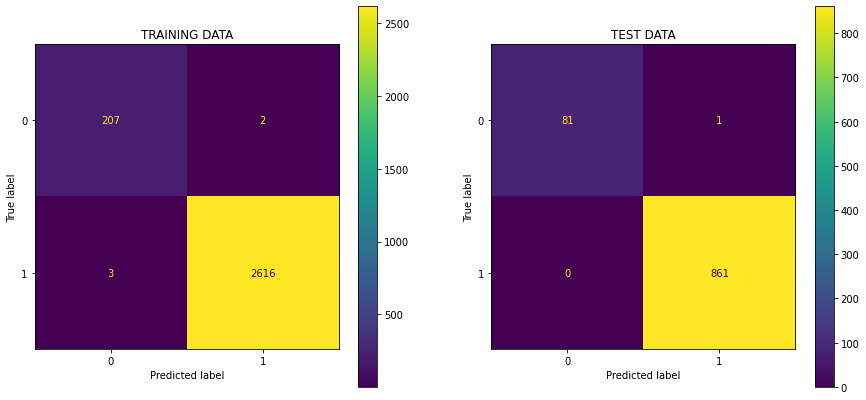

In [ ]:
prediction(model, X_train, y_train, X_test, y_test)

## Model Selection

In [ ]:
scores = [lr_score, dt_score, rf_score, ada_score, gb_score]
model = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Adaptive Boosting', 'Gradient Boosting']
scores_df = pd.DataFrame(data = scores, index = model, columns = ['score'])

In [ ]:
scores_df.sort_values(by = 'score', ascending = False)

- Overall, `Gradient Boosting Algorithm` performs the best on the trainnig as well as the test data. So we will use this model for production.

## Getting ready for production

In [ ]:
import joblib

In [ ]:
joblib.dump(pipeline, 'pipe.joblib')

['pipe.joblib']

In [ ]:
same_pipe = joblib.load('pipe.joblib')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        82
           1       1.00      1.00      1.00       861

    accuracy                           1.00       943
   macro avg       1.00      0.99      1.00       943
weighted avg       1.00      1.00      1.00       943



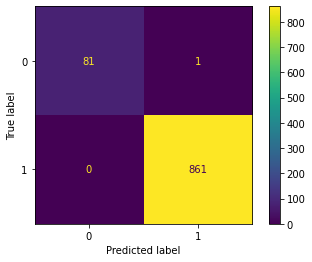

In [ ]:
preds = same_pipe.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(same_pipe, X_test, y_test)